# Chapter 07 — Downsampled UMAP and Doublet Analysis

### Objective

In this chapter, we load the AnnDatas that we saved in the last chapter, process them using the typical Scanpy workflow (guided by Roshan's workshop and sc-best-practices). Doublet prediction will be done using Scrublet. Clusters with poor quality cells will be removed and the resulting AnnDatas will be saved for cell typing in the next chapter.

This includes:

- Reading in AnnDatas from the correct input directory
- Running Scrublet on the raw data
- Performing preprocessing and graph computation using the standard Scanpy pipeline
- Creting plots colored by protocol, library size, leiden clusters, predicted doublets, and other metrics that may be relevant
- Plot doublets vs non-doublets stratified by cluster
- Plot boxplots with library size, gene detection, and mitochondrial content by cluster in order to identify poor quality clusters
- Saving the AnnDatas with bad clusters removed and AnnDatas with PCA, UMAP, and neighbors graph computed to the correct output directory

### Data Inputs and Outputs

- AnnDatas will come from "adatas/adatas_X_downsampled_with_gene_metrics"
- Combined (by tissue) AnnDatas will be outputed to "adatas/combined_adatas_downsampled_clusters_removed" as well as
- Figures will be outputted to "figures/chapter_07_downsampled_umap_doublet_analysis"

##### Run Autoreload (Automically Reloads Edited Module Files)

In [2]:
%load_ext autoreload
%autoreload 2

#### Imports

In [3]:
import os

import numpy as np
import scanpy as sc

import utils
import utils.config as config

### File Paths

In [4]:
# File and directory paths
figures_output_dir = config.FIGURES_DIR / "chapter_07_downsampled_umap_doublet_analysis"
input_adata_dir = config.ADATA_DIR / "adatas_X_downsampled_with_gene_metrics"
output_adata_dir = config.ADATA_DIR / "combined_adatas_downsampled_clusters_removed"

# Make sure output directories exist
os.makedirs(figures_output_dir, exist_ok=True)
os.makedirs(output_adata_dir, exist_ok=True)

### Read in AnnDatas

In [5]:
# Load AnnData objects
adata_dict = {}
sample_metadata = config.SAMPLES_METADATA

for key, sample_info in sample_metadata.items():
    tissue = sample_info["tissue"]
    protocol = sample_info["protocol"]

    file_path = os.path.join(
        input_adata_dir,
        f"{key}_adata.h5ad",
    )

    adata = sc.read_h5ad(file_path)
    adata_dict[key] = adata
    print(f"{key}: {adata}")

SF_N: AnnData object with n_obs × n_vars = 7179 × 32527
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'total_counts_mitochondrial', 'pct_counts_mitochondrial', 'total_counts_ribosomal', 'pct_counts_ribosomal', 'total_counts_apoptosis', 'pct_counts_apoptosis', 'total_counts_housekeeping', 'pct_counts_housekeeping'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mitochondrial', 'ribosomal', 'apoptosis', 'housekeeping'
    layers: 'downsampled_umi', 'not_downsampled_raw'
SL_N: AnnData object with n_obs × n_vars = 7929 × 33481
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'total_counts_mitochondrial', 'pct_counts_mitochondrial', 'total_counts_ribosomal', 'pct_counts_ribosomal', 'total_counts_apoptosis', 'pct_counts_apoptosis', 'total_counts_housekeepi

## Doublet Detection

In [7]:
def run_scrublet(adata: sc.AnnData) -> None:
    """
    Run Scrublet doublet detection on the given AnnData object.

    Parameters:
    adata (sc.AnnData): The AnnData object to analyze.
    """
    sc.pp.scrublet(
        adata,
        sim_doublet_ratio=2.0,
        expected_doublet_rate=0.06,
        knn_dist_metric="euclidean",
        log_transform=True,
        n_prin_comps=30,
        random_state=0,
    )  # From Roshan's workshop


for key, adata in adata_dict.items():
    print(f"Running Scrublet on {key}...")
    run_scrublet(adata)

Running Scrublet on SF_N...


adata.X seems to be already log-transformed.


Running Scrublet on SL_N...


adata.X seems to be already log-transformed.


Running Scrublet on SF_T...


adata.X seems to be already log-transformed.


Running Scrublet on SL_T...


adata.X seems to be already log-transformed.


Running Scrublet on SF_LN...


adata.X seems to be already log-transformed.


Running Scrublet on SL_LN...


adata.X seems to be already log-transformed.


### Preprocessing and Graph Computation

In [ ]:
tissue_order = config.TISSUE_ORDER

# Use downsampled reads for analysis
for key, adata in adata_dict.items():
    adata.layers["raw_data"] = adata.X.copy()
    sc.pp.normalize_total(
        adata, target_sum=None, inplace=True
    )  # From both Roshan and sc-best-practices
    sc.pp.log1p(adata)

# Combine adatas by tissue
combined_by_tissue = {}
for tissue in tissue_order:
    tissue_adatas = []
    for key, sample_info in sample_metadata.items():
        tissue_name = sample_info["tissue"]
        protocol = sample_info["protocol"]

        # Only include adata if it matches the current tissue
        if tissue_name == tissue:
            adata = adata_dict[key].copy()
            adata.obs["protocol"] = protocol
            adata.obs["tissue"] = tissue
            adata.obs["sample"] = key
            tissue_adatas.append(adata)

    combined = sc.concat(
        tissue_adatas,
        label="sample",
        keys=[a.obs["sample"].iloc[0] for a in tissue_adatas],
    )

    combined_by_tissue[tissue] = utils.process_adata(adata = combined)

/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.w

### UMAP Plots

#### Plot by Protocol

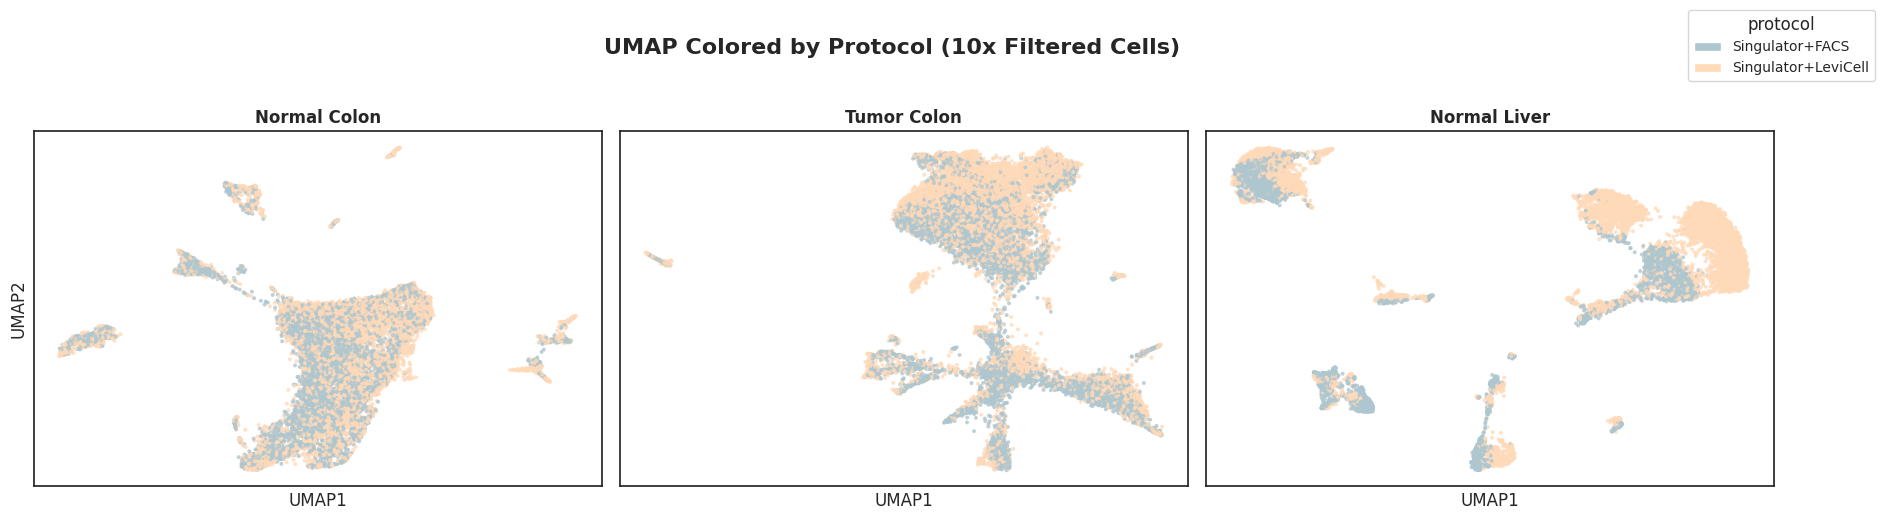

In [ ]:
protocol_color_palette = config.PROTOCOL_COLOR_PALETTE

# Plot UMAP colored by protocol
fig = utils.plot_umap_by_obs_feature(
    combined_by_tissue=combined_by_tissue,
    feature="protocol",
    color_palette=protocol_color_palette,
    title="UMAP Colored by Protocol (10x Filtered Cells)",
)

# Save the figure
fig.savefig(
    os.path.join(figures_output_dir, "umap_by_protocol.png"), bbox_inches="tight"
)

### Plot by Library Size

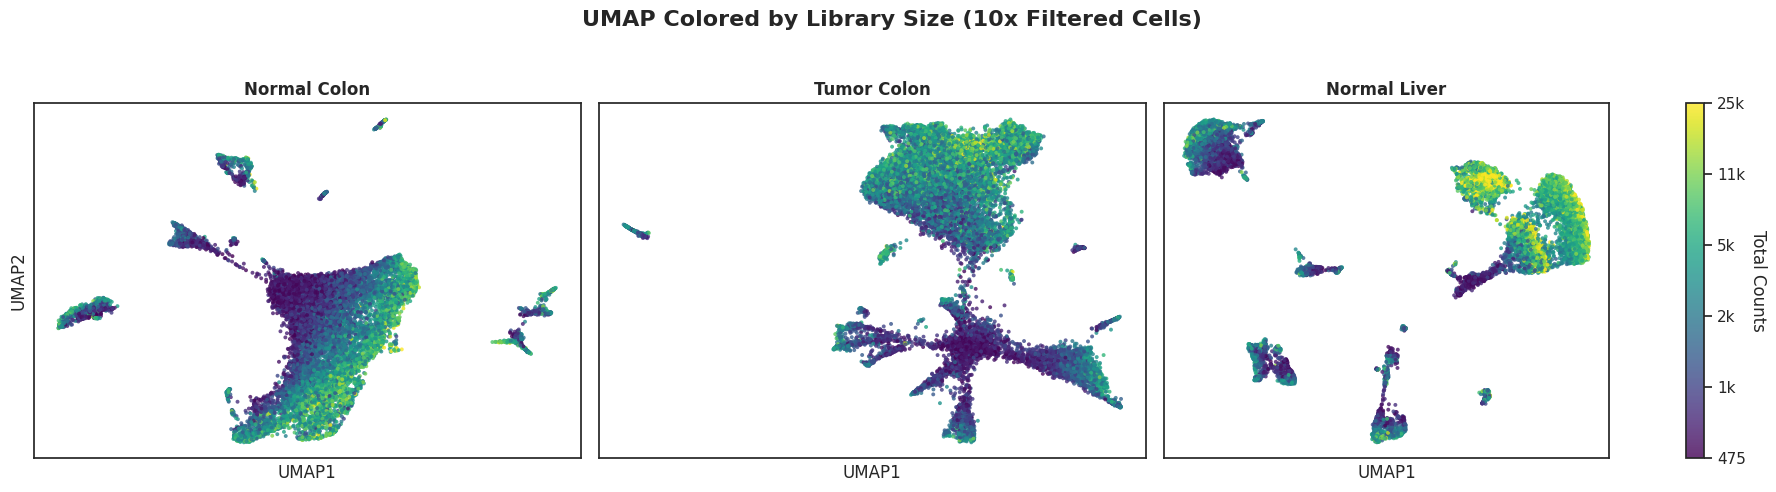

In [ ]:
# Plot UMAP colored by protocol
fig = utils.plot_umap_by_obs_feature(
    combined_by_tissue=combined_by_tissue,
    feature="total_counts",
    color_palette="viridis",
    log_scale=True,
    clip_values=(0.0005, 0.99),
    title="UMAP Colored by Library Size (Downsampled 10x Filtered Cells)",
)

# Save the figure
fig.savefig(
    os.path.join(figures_output_dir, "umap_by_library_size.png"), bbox_inches="tight"
)

### Plot by Leiden Cluster

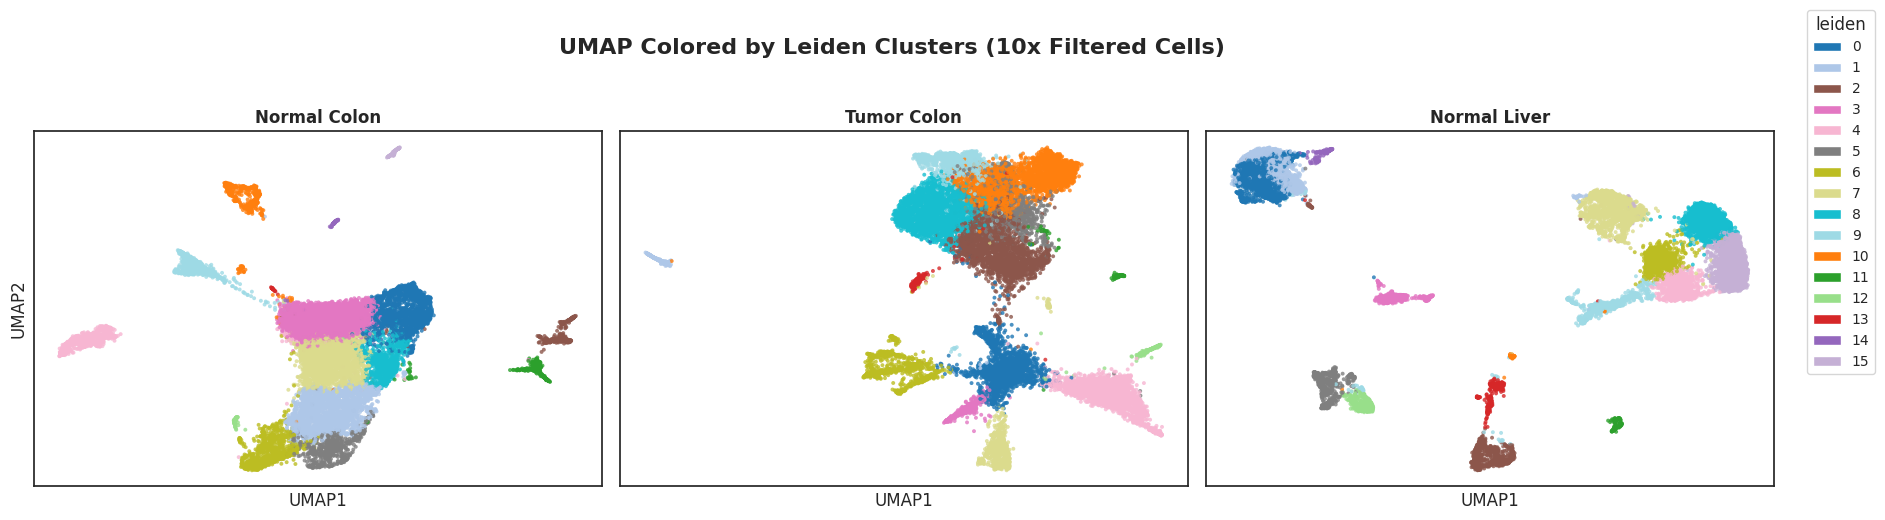

In [ ]:
# Plot UMAP colored by leiden cluster
fig = utils.plot_umap_by_obs_feature(
    combined_by_tissue=combined_by_tissue,
    feature="leiden",
    color_palette="tab20",
    title="UMAP Colored by Leiden Clusters (Downsampled 10x Filtered Cells)",
)

# Save the figure
fig.savefig(os.path.join(figures_output_dir, "umap_by_leiden.png"), bbox_inches="tight")

### Cluster by Protocol Stackplots

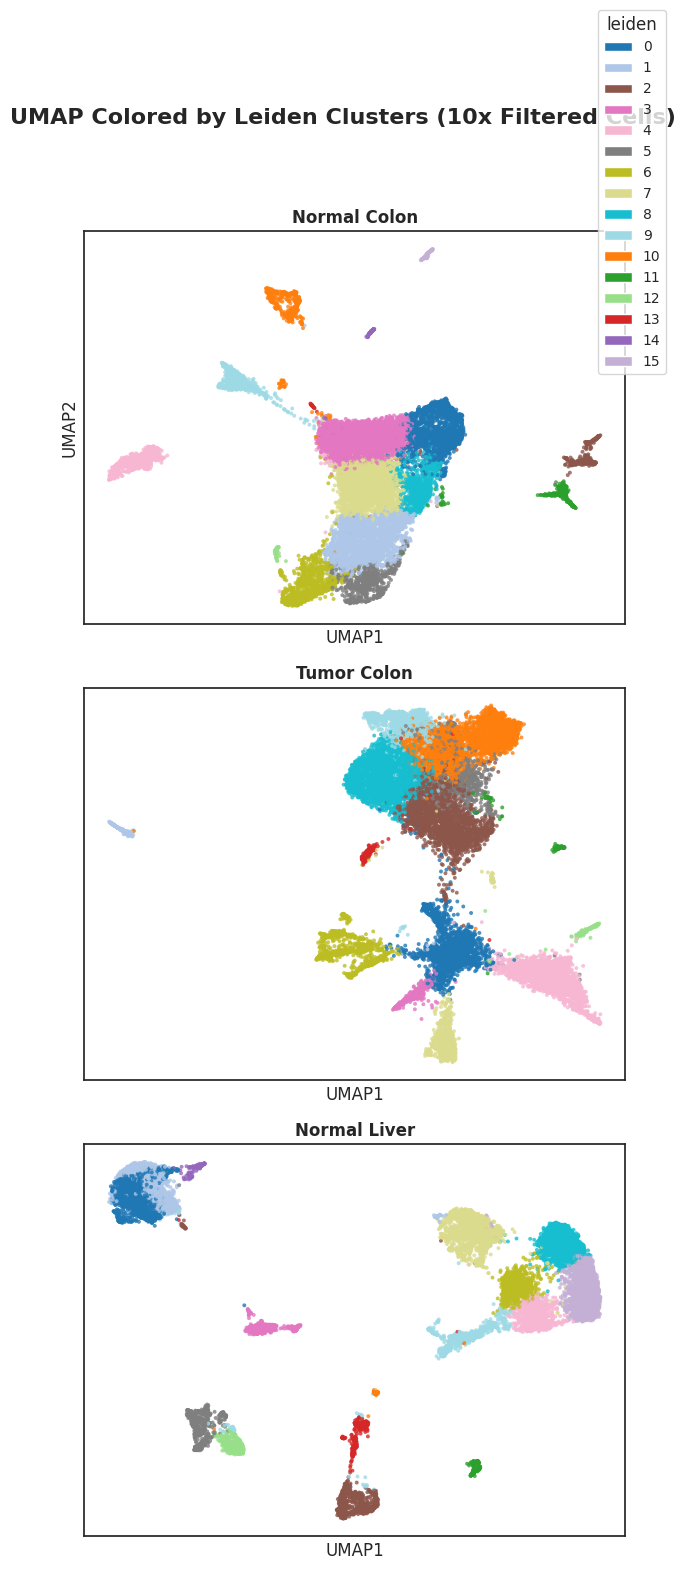

In [ ]:
# Plot cluster composition by protocol across tissues
fig = utils.plot_cluster_protocol_stackplots(
    combined_by_tissue=combined_by_tissue,
    cluster_key="leiden",
    protocol_key="protocol",
    protocol_color_palette=protocol_color_palette,
    title="Cluster Composition by Protocol Across Tissues (Downsampled 10x Filtered Cells)",
    tissue_order=tissue_order,
)

# Save the figure
fig.savefig(
    os.path.join(figures_output_dir, "cluster_stackplot_cellranger_filtered.png"),
    bbox_inches="tight",
)

### Cluster by Protocol Stackplots

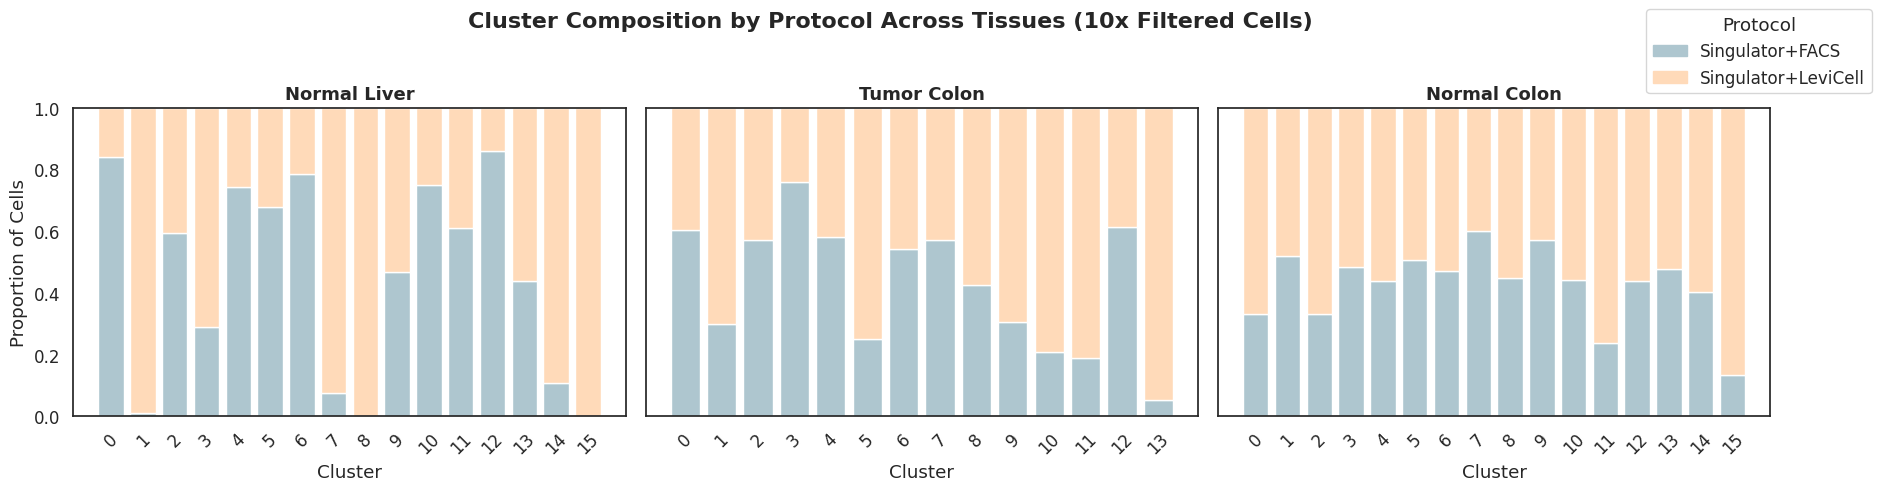

In [ ]:
# Plot cluster composition by protocol across tissues
fig = utils.plot_cluster_protocol_stackplots(
    combined_by_tissue=combined_by_tissue,
    cluster_key="leiden",
    protocol_key="protocol",
    protocol_color_palette=protocol_color_palette,
    title="Cluster Composition by Protocol Across Tissues (Downsampled 10x Filtered Cells)",
    tissue_order=tissue_order,
)

# Save the figure
fig.savefig(
    os.path.join(figures_output_dir, "cluster_stackplot_cellranger_filtered.png"),
    bbox_inches="tight",
)

#### UMAP Colored by Mitochondrial Gene Content

In [ ]:
fig = utils.plot_umap_by_obs_feature(
    combined_by_tissue=combined_by_tissue,
    feature="pct_counts_mitochondrial",
    color_palette="inferno",
    log_scale=True,
    title="UMAP Colored by Mitochondrial Percentage (Downsampled 10x Filtered Cells)",
    tissue_order=tissue_order,
)

# Save the figure
fig.savefig(
    os.path.join(figures_output_dir, "umap_by_mitochondrial.png"),
    bbox_inches="tight",
)

## Doublets

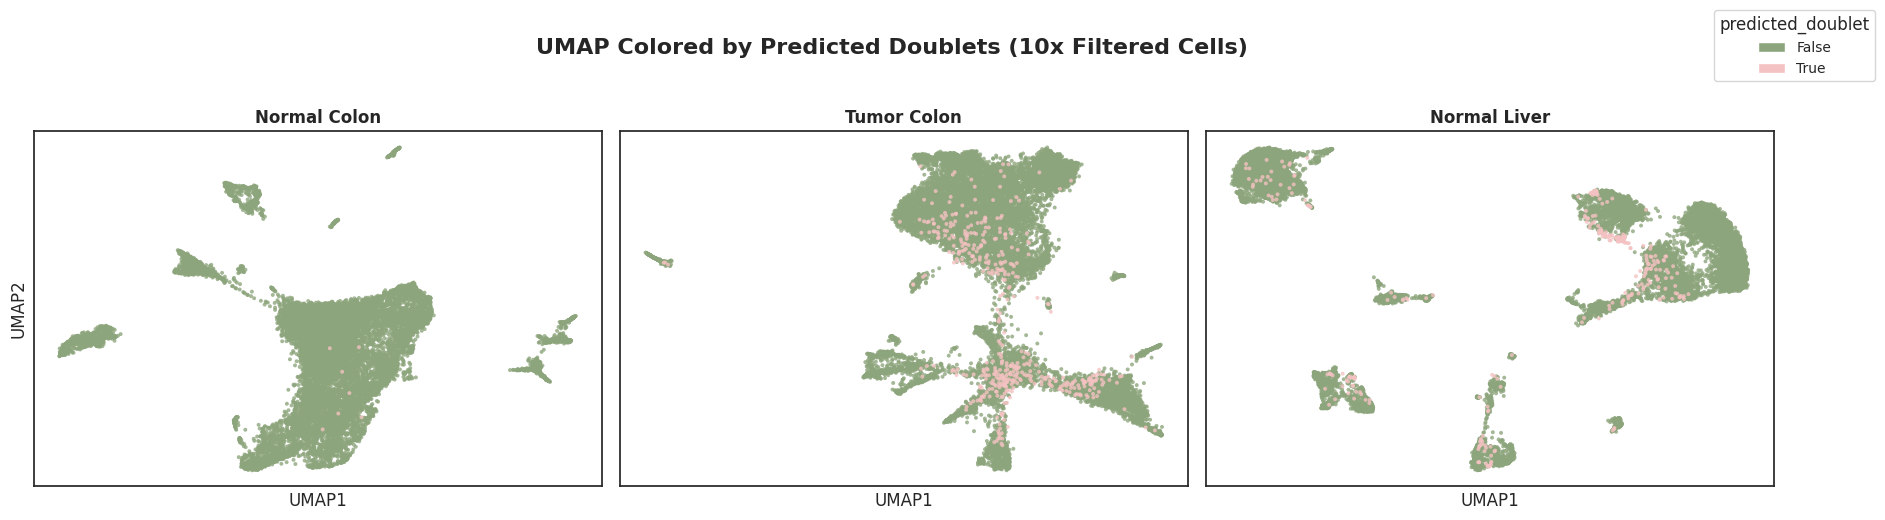

In [ ]:
# Get doublet color palette
doublet_color_palette = config.DOUBLET_COLOR_PALETTE

fig = utils.plot_umap_by_obs_feature(
    combined_by_tissue=combined_by_tissue,
    feature="predicted_doublet",
    color_palette=doublet_color_palette,
    title="UMAP Colored by Predicted Doublets (Downsampled 10x Filtered Cells)",
    tissue_order=tissue_order,
)

# Save the figure
fig.savefig(
    os.path.join(figures_output_dir, "umap_by_predicted_doublets.png"),
    bbox_inches="tight",
)

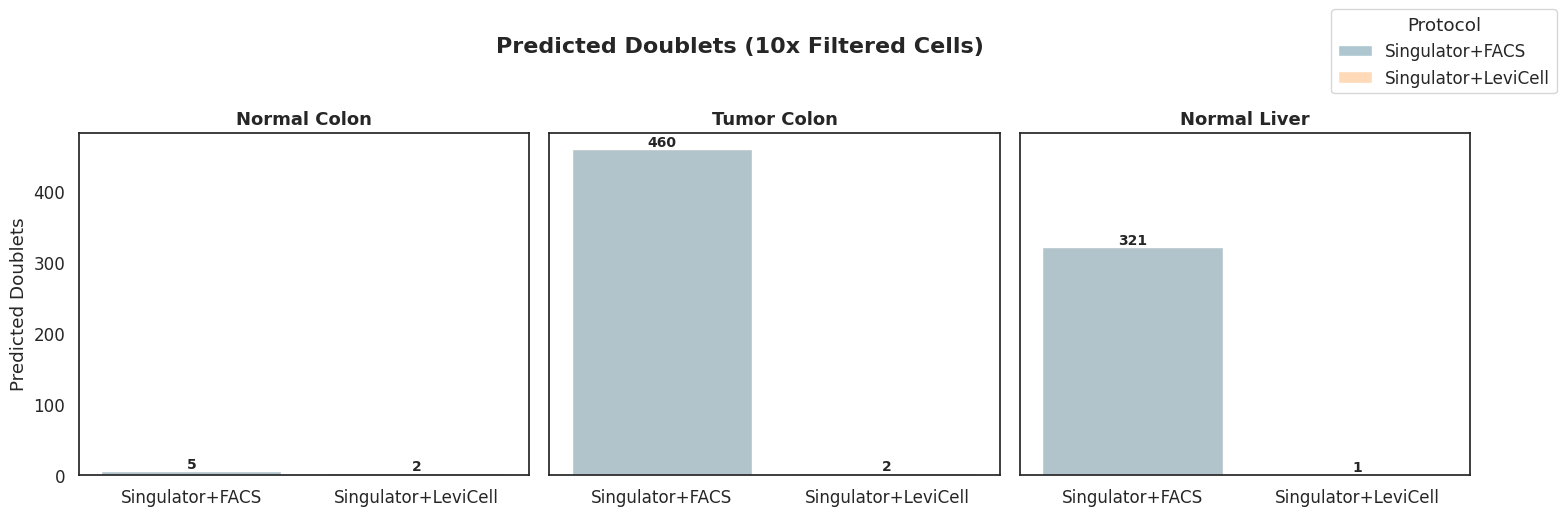

In [ ]:
# Plot number of cells
fig = utils.plot_scalar_metric(
    data_dict=adata_dict,
    metadata=sample_metadata,
    metric_func=lambda adata: int(adata.obs["predicted_doublet"].sum()),
    metric_label="Predicted Doublets",
    protocol_color_palette=protocol_color_palette,
    title="Predicted Doublets (Downsampled 10x Filtered Cells)",
    tissue_order=tissue_order,
)

# Save the figure
fig.savefig(
    os.path.join(figures_output_dir, "predicted_doublets_by_protocol.png"),
    bbox_inches="tight",
)

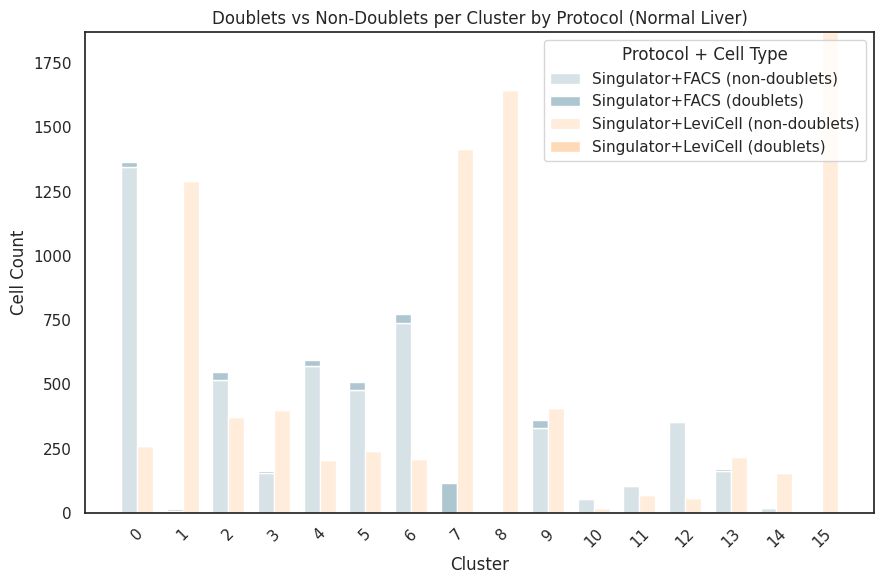

In [ ]:
fig = utils.plot_doublet_stack_by_cluster(
    combined_by_tissue=combined_by_tissue,
    tissue="Normal Liver",
    color_palette=protocol_color_palette,
)

# Save the figure
fig.savefig(
    os.path.join(figures_output_dir, "doublet_stackplot_normal_liver.png"),
    bbox_inches="tight",
)

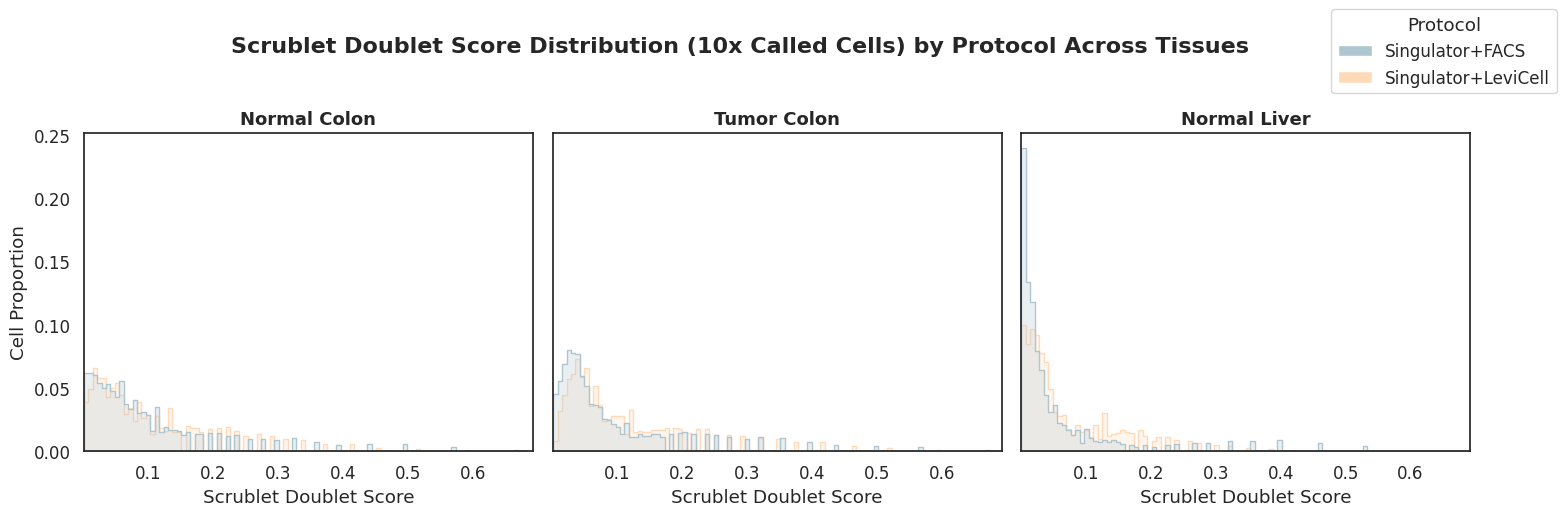

In [ ]:
# Plot doublet score distribution
fig = utils.plot_adata_metric_histogram(
    adata_dict=adata_dict,
    sample_metadata=sample_metadata,
    field="doublet_score",
    axis="obs",
    log_x=False,
    x_label="Scrublet Doublet Score",
    title="Scrublet Doublet Score Distribution (Downsampled 10x Called Cells) by Protocol Across Tissues",
    protocol_color_palette=protocol_color_palette,
    proportion=True,
    tissue_order=tissue_order,
)

# Save the figure
fig.savefig(
    os.path.join(figures_output_dir, "scrublet_doublet_score_historgram.png"),
    bbox_inches="tight",
)

### Boxplot Metrics by Cluster

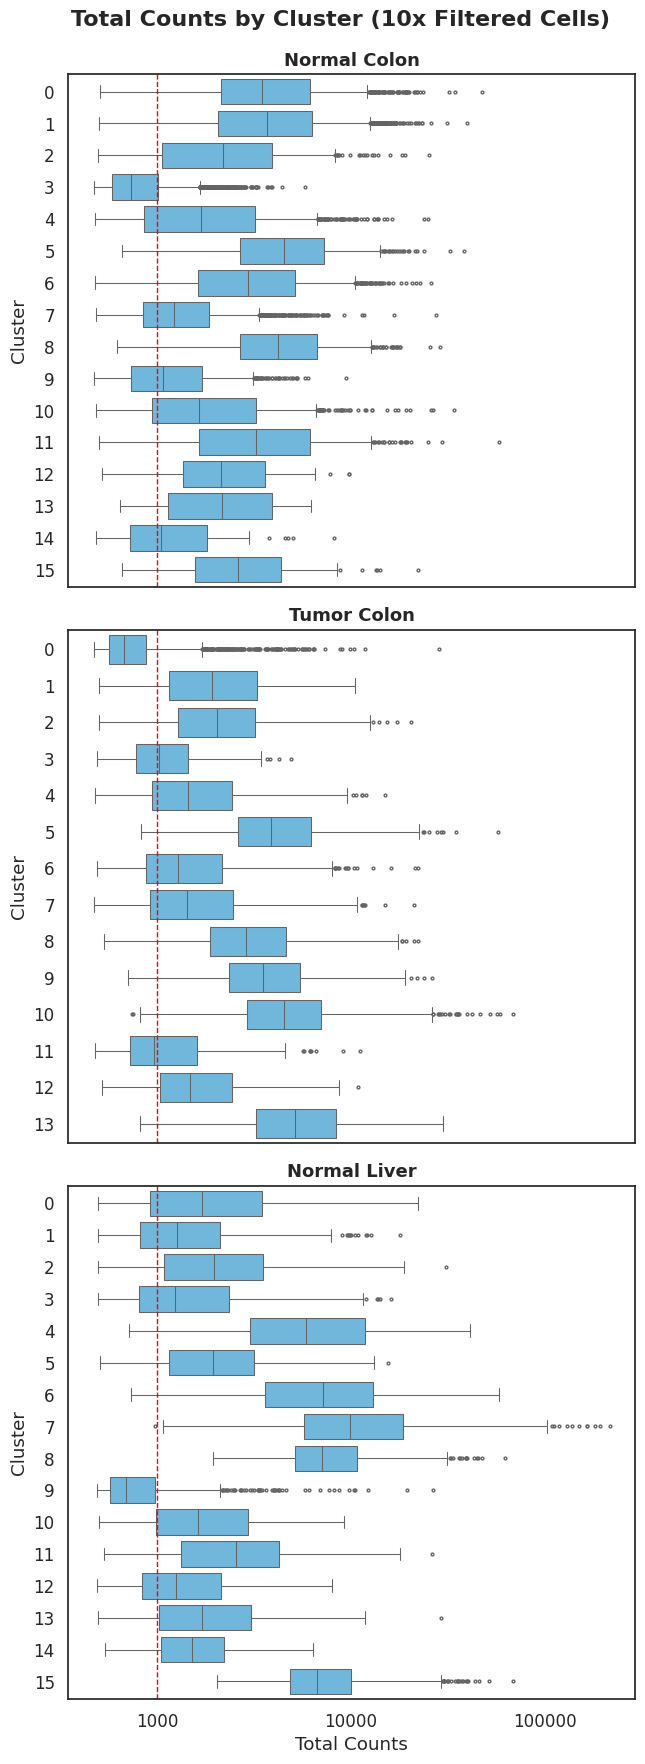

In [ ]:
# Plot total counts by cluster
fig = utils.plot_cluster_metric_boxplots(
    combined_by_tissue,
    metric="total_counts",
    log_scale=True,
    axline=1000, # Somewhat arbitrary cutoff for total counts
    vertical=True,
    title="Total Counts by Cluster (Downsampled 10x Filtered Cells)",
    tissue_order=tissue_order,
)

# Save the figure
fig.savefig(
    os.path.join(figures_output_dir, "total_counts_by_cluster.png"),
    bbox_inches="tight",
)

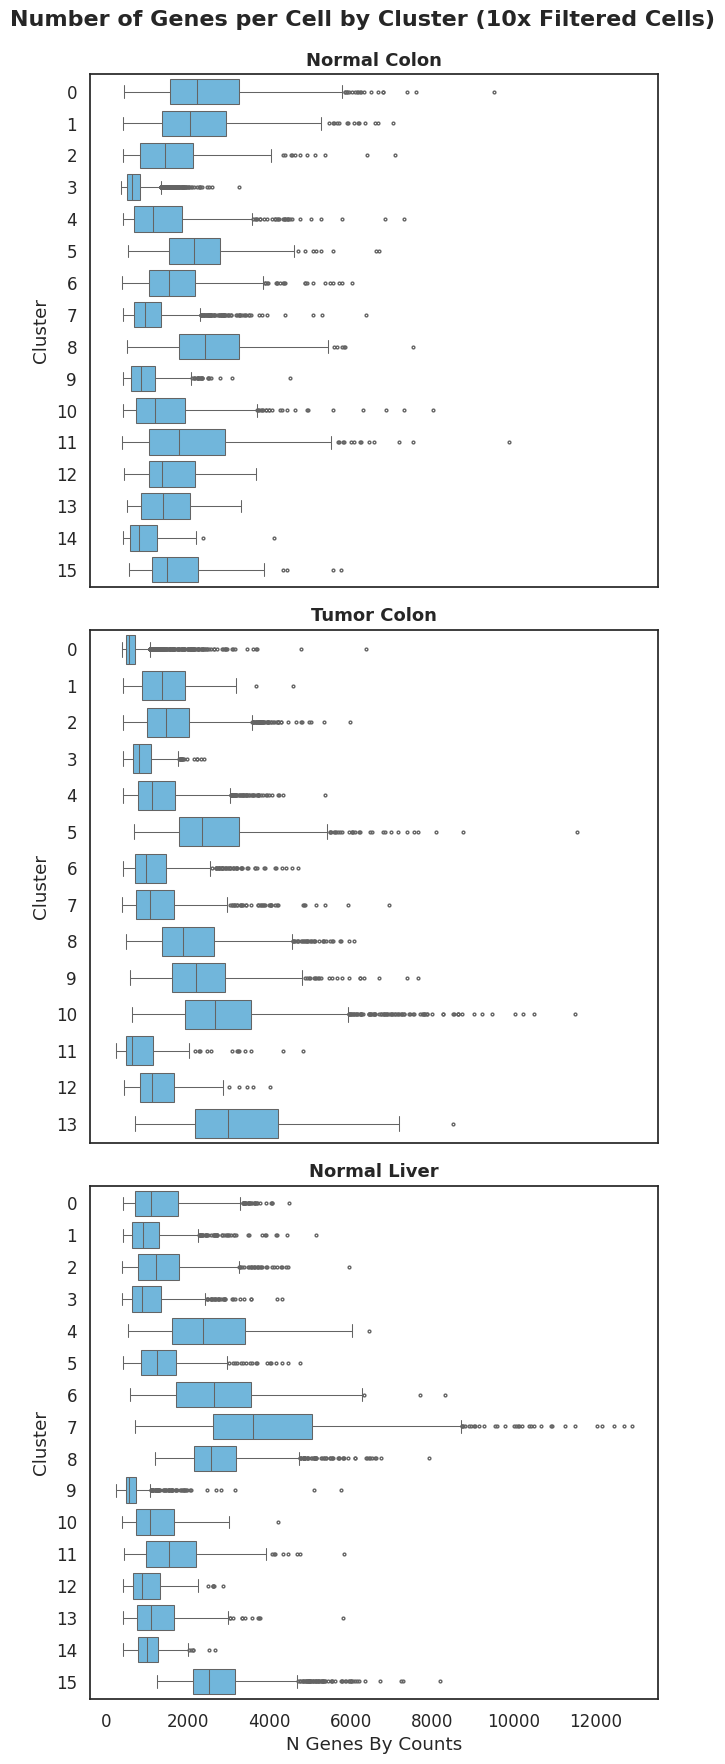

In [ ]:
# Plot number of genes by counts by cluster
fig = utils.plot_cluster_metric_boxplots(
    combined_by_tissue,
    metric="n_genes_by_counts",
    log_scale=False,
    axline=None,
    vertical=True,
    title="Number of Genes per Cell by Cluster (Downsampled 10x Filtered Cells)",
    tissue_order=tissue_order,
)

# Save the figure
fig.savefig(
    os.path.join(figures_output_dir, "n_genes_by_counts_by_cluster.png"),
    bbox_inches="tight",
)

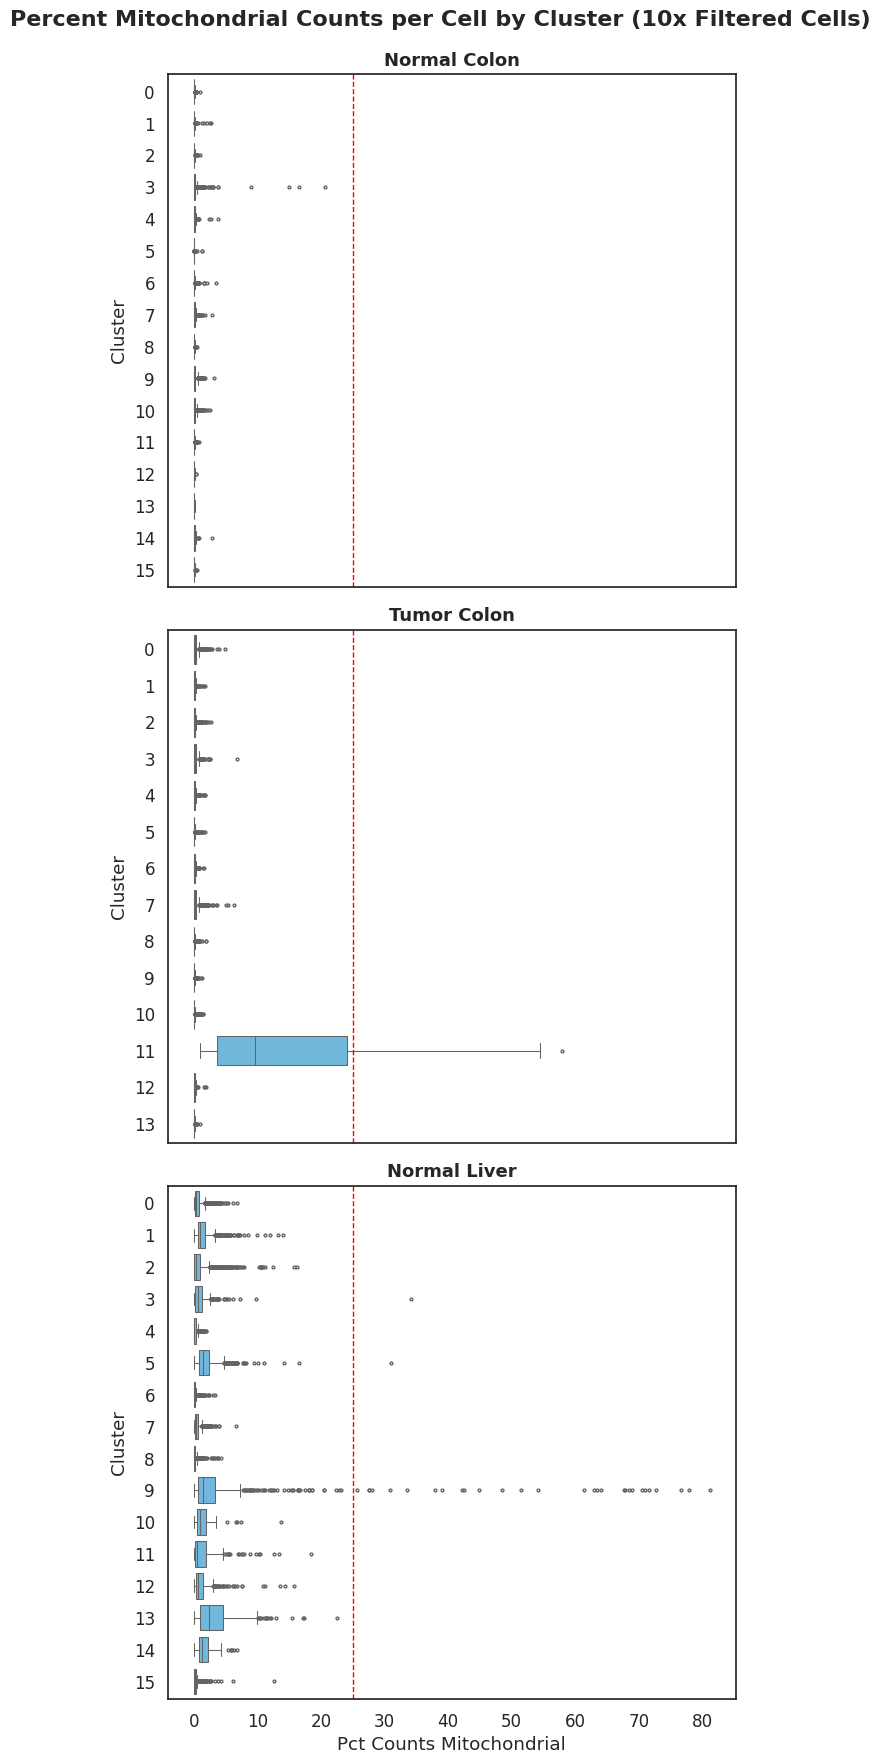

In [ ]:
# Plot percent mitochondrial counts by cluster
fig = utils.plot_cluster_metric_boxplots(
    combined_by_tissue,
    metric="pct_counts_mitochondrial",
    vertical=True,
    log_scale=False,
    axline=25,
    title="Percent Mitochondrial Counts per Cell by Cluster (Downsampled 10x Filtered Cells)",
    tissue_order=tissue_order,
)

# Save the figure
fig.savefig(
    os.path.join(figures_output_dir, "pct_counts_mitochondrial_by_cluster.png"),
    bbox_inches="tight",
)

#### Remove Clusters Based on Boxplots Above

In [ ]:
normal_colon_clusters_to_remove = ["3"]
tumor_colon_clusters_to_remove = ["0"]
normal_liver_clusters_to_remove = ["9"]

# Normal Colon
normal_colon_combined_adata = combined_by_tissue["Normal Colon"].copy()
print(f"Normal Colon Combined AnnData: {normal_colon_combined_adata}")
normal_colon_combined_adata = normal_colon_combined_adata[
    normal_colon_combined_adata.obs["leiden"].isin(normal_colon_clusters_to_remove) == False
].copy()
print(f"Normal Colon Combined AnnData after filtering: {normal_colon_combined_adata}")

# Tumor Colon
tumor_colon_combined_adata = combined_by_tissue["Tumor Colon"].copy()
print(f"Tumor Colon Combined AnnData: {tumor_colon_combined_adata}")
tumor_colon_combined_adata = tumor_colon_combined_adata[
    tumor_colon_combined_adata.obs["leiden"].isin(tumor_colon_clusters_to_remove) == False
].copy()
print(f"Tumor Colon Combined AnnData after filtering: {tumor_colon_combined_adata}")

# Normal Liver
normal_liver_combined_adata = combined_by_tissue["Normal Liver"].copy()
print(f"Normal Liver Combined AnnData: {normal_liver_combined_adata}")
normal_liver_combined_adata = normal_liver_combined_adata[
    normal_liver_combined_adata.obs["leiden"].isin(normal_liver_clusters_to_remove) == False
].copy()
print(f"Normal Liver Combined AnnData after filtering: {normal_liver_combined_adata}")

Normal Colon Combined AnnData: AnnData object with n_obs × n_vars = 15108 × 19118
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'total_counts_mitochondrial', 'pct_counts_mitochondrial', 'total_counts_ribosomal', 'pct_counts_ribosomal', 'total_counts_apoptosis', 'pct_counts_apoptosis', 'total_counts_housekeeping', 'pct_counts_housekeeping', 'doublet_score', 'predicted_doublet', 'protocol', 'tissue', 'sample', 'n_genes', 'leiden'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'downsampled_umi', 'raw_data', 'downsampled_raw'
    obsp: 'distances', 'connectivities'
Normal Colon Combined AnnData after filtering: AnnData object with n_obs × n_vars = 11245 × 19118
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_t

#### Reprocess AnnDatas with Clusters Removed

In [ ]:
# Process each combined adata
utils.process_adata(adata = normal_colon_combined_adata)
utils.process_adata(adata = tumor_colon_combined_adata)
utils.process_adata(adata = normal_liver_combined_adata)

#### Redo UMAP Plots with Clusters Removed

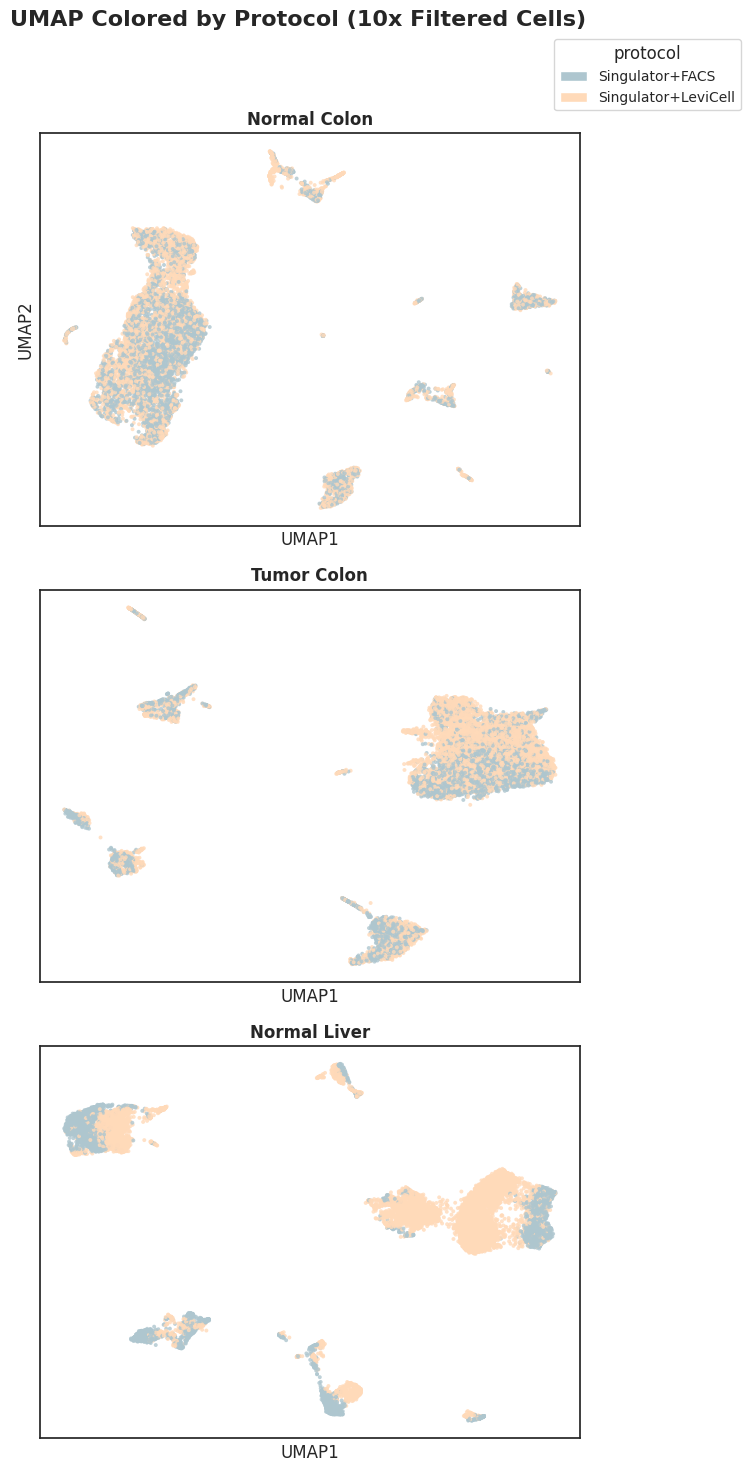

In [ ]:
combined_by_tissue_clusters_removed = {}

combined_by_tissue_clusters_removed["Normal Colon"] = normal_colon_combined_adata
combined_by_tissue_clusters_removed["Tumor Colon"] = tumor_colon_combined_adata
combined_by_tissue_clusters_removed["Normal Liver"] = normal_liver_combined_adata

# Plot UMAP colored by protocol
fig = utils.plot_umap_by_obs_feature(
    combined_by_tissue=combined_by_tissue_clusters_removed,
    feature="protocol",
    color_palette=protocol_color_palette,
    title="UMAP Colored by Protocol (Downsampled 10x Filtered Cells)",
    vertical=True,
    legend_bbox_to_anchor=(1.25, 0.965),
)

# Save the figure
fig.savefig(
    os.path.join(figures_output_dir, "umap_by_protocol_clusters_removed.png"),
    bbox_inches="tight",
)

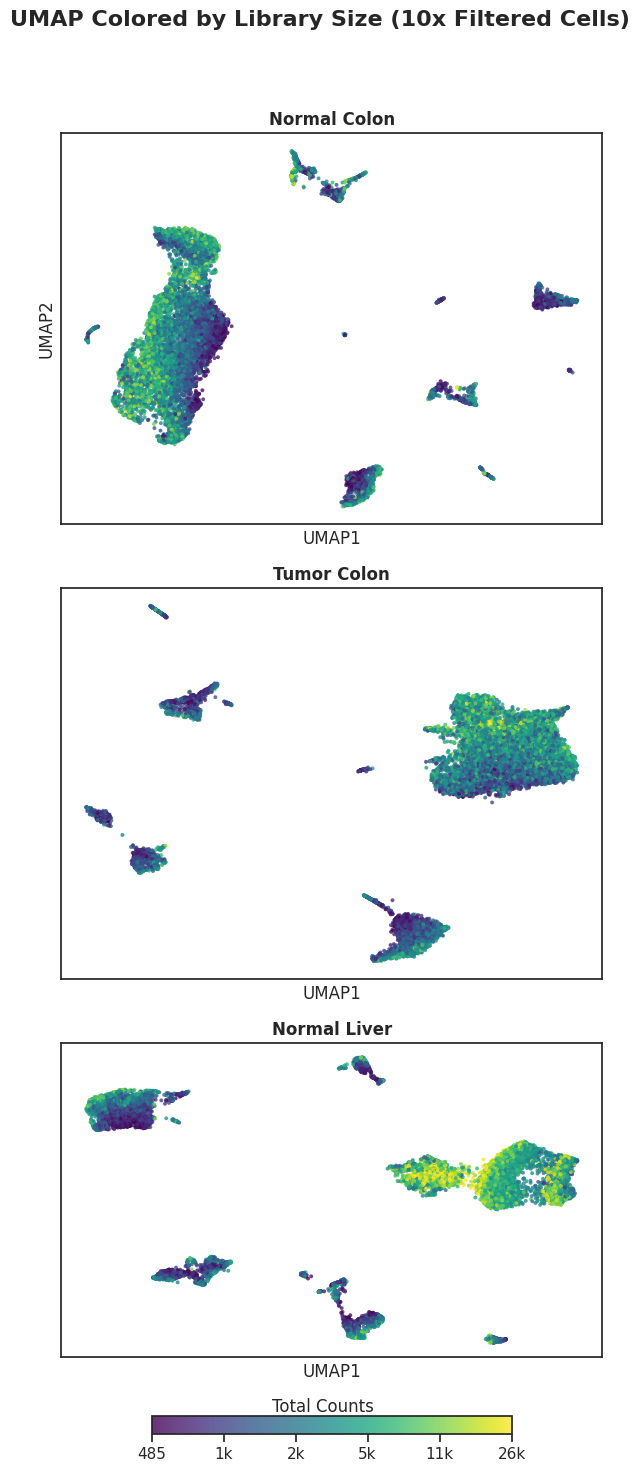

In [ ]:
# Plot UMAP colored by protocol
fig = utils.plot_umap_by_obs_feature(
    combined_by_tissue=combined_by_tissue_clusters_removed,
    feature="total_counts",
    color_palette="viridis",
    log_scale=True,
    clip_values=(0.0005, 0.99),
    title="UMAP Colored by Library Size (Downsampled 10x Filtered Cells)",
    vertical=True,
    legend_bbox_to_anchor=(1.25, 0.965),
)

# Save the figure
fig.savefig(
    os.path.join(figures_output_dir, "umap_by_library_size_clusters_removed.png"),
    bbox_inches="tight",
)

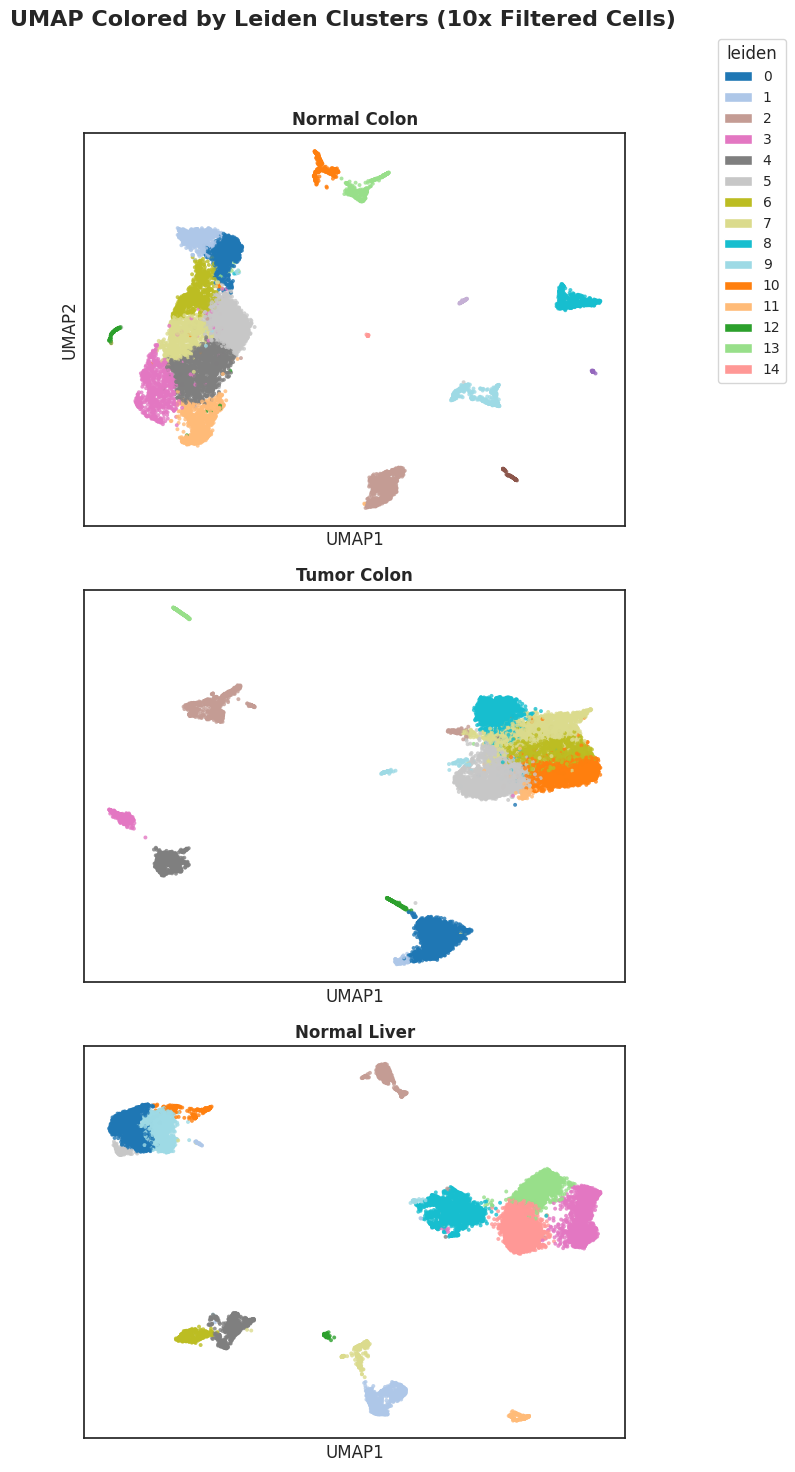

In [ ]:
# Plot UMAP colored by leiden cluster
fig = utils.plot_umap_by_obs_feature(
    combined_by_tissue=combined_by_tissue_clusters_removed,
    feature="leiden",
    color_palette="tab20",
    title="UMAP Colored by Leiden Clusters (Downsampled 10x Filtered Cells)",
    vertical=True,
    legend_bbox_to_anchor=(1.25, 0.965),
)

# Save the figure
fig.savefig(
    os.path.join(figures_output_dir, "umap_by_leiden_clusters_removed.png"),
    bbox_inches="tight",
)

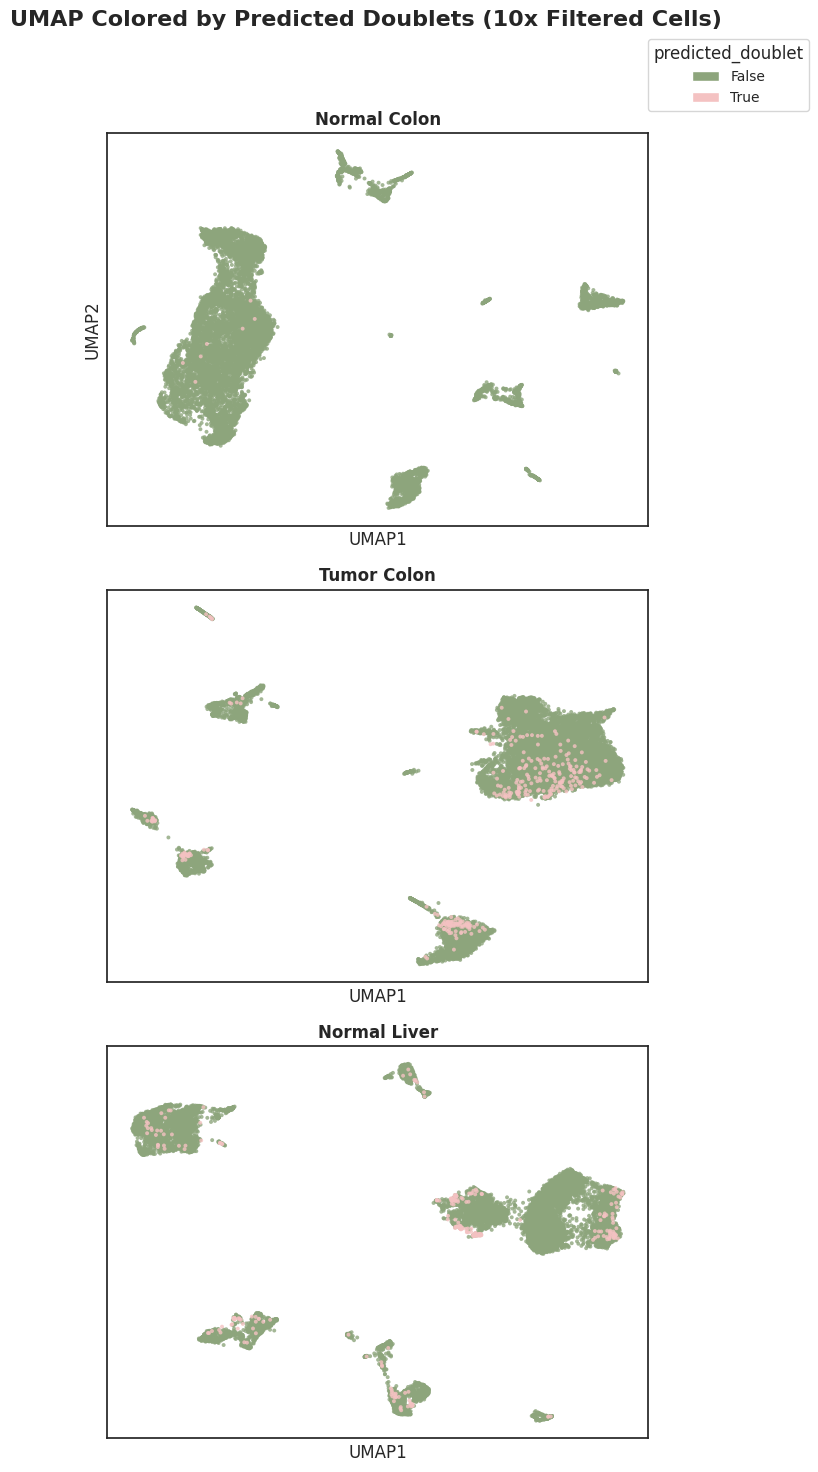

In [ ]:
fig = utils.plot_umap_by_obs_feature(
    combined_by_tissue=combined_by_tissue_clusters_removed,
    feature="predicted_doublet",
    color_palette=doublet_color_palette,
    title="UMAP Colored by Predicted Doublets (Downsampled 10x Filtered Cells)",
    vertical=True,
    legend_bbox_to_anchor=(1.25, 0.965),
)

# Save the figure
fig.savefig(
    os.path.join(figures_output_dir, "umap_by_predicted_doublets_clusters_removed.png"),
    bbox_inches="tight",
)

#### Save AnnDatas to File

In [ ]:
for tissue_adata in combined_by_tissue_clusters_removed.items():
    tissue = sample_info["tissue"]
    protocol = sample_info["protocol"]

    output_file = os.path.join(
        output_adata_dir,
        f"{tissue.replace(' ', '_')}_combined_adata_clusters_removed.h5ad",
    )

    adata.write(output_file)
    print(f"Saved {tissue} combined AnnData to {output_file}")

Saved Normal Colon combined AnnData to ./data/analysis/adatas/combined_adatas_downsampled_clusters_removed/Normal_Colon_combined_adata_clusters_removed.h5ad
Saved Tumor Colon combined AnnData to ./data/analysis/adatas/combined_adatas_downsampled_clusters_removed/Tumor_Colon_combined_adata_clusters_removed.h5ad
Saved Normal Liver combined AnnData to ./data/analysis/adatas/combined_adatas_downsampled_clusters_removed/Normal_Liver_combined_adata_clusters_removed.h5ad


: 